### Image Sharpening with a Point Spread Function

Anni Li

In this project, I will explore applications of Fast Fourier Transform in blurring and unblurring the image. This project includes the following sections: <br>
1. Blur and unblur the grayscale cartoon image <br>
    (a) Unblur it directly <br>
    (b) Unblur the loaded image <br>
    (c) Use Wiener Deconvolution to unblur the loaded blurred image<br>
2. Blur and unblur the RGB real image (which has an additional dimension) <br>
    (a) Unblur it directly <br>
    (b) Unblur the loaded image <br>
    (c) Use Wiener Deconvolution to unblur the loaded blurred image<br>
3. When PSF is not analytic <br>
    (a) Get PSF from blurred and filtered images <br>
    (b) Use this PSF to blur and directly unblur the target image <br>
    (c) Use this PSF to unblur the loaded blurred image <br>
    (d) Use Wiener Deconvolution to unblur the loaded blurred image

References:
1. Class notes on FFT <br>
2. https://youtu.be/f-IINpceX6k <br>
3. https://irsa.ipac.caltech.edu/data/SPITZER/docs/irac/calibrationfiles/psfprf/

#### 0: Import necessary packages

In [1]:
# cv2 is a module from the OpenCV library, which can facilitate image processing
import cv2
import numpy as np
from matplotlib import pyplot as plt
# functions for fourier transform manipulations
from numpy.fft import fft, ifft, fftn, ifftn, fftfreq

#### 1. Blur and unblur the grayscale cartoon image

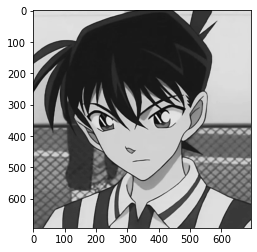

In [2]:
# read the image from local
cartoon = cv2.imread('detective.jpg')
# use cv2 to convert it to grayscale (no color channels)
cartoon_gray = cv2.cvtColor(cartoon, cv2.COLOR_BGR2GRAY)
# show the grayscale image
plt.imshow(cartoon_gray, cmap='gray')

To blur the image use a point spread function, we use

$$
\text{blur} = \int dx' \, dy' \, \text{image}(x',y') \, \text{PSF}(x-x', y-y')
$$


For PSF here we choose gaussian $$ e^{-(x-x')^2 - (y-y')^2}$$

In Fourier space, we have

$$
\text{blur}_F(k_x, k_y) = \text{image}_F(k_x, k_y) \text{ PSF}_F(k_x, k_y)
$$

Where kx, ky calculate the spatial frequencies in the x and y directions.The fourier transform changes the image from pixel intensities in spatial domain (x, y) to frequency components, each with an amplitude and phase. This allows us to do the convolution easier, since convolutions in spatial space is products in fourier space.

So what we need is to calculate kx and ky of the image to get the PSF in fourier space. Then we need to fourier transform the image and multiply it with fourier transformed PSF, and then inverse fourier transform the result to get the blurred image in spatial domain.

In [3]:
# function to calculate kx and ky
def calc_kxky(img):
    # get the height and width of the image
    h, w = img.shape[:2]
    
    ## fftfreq(lenth) returns an array that contains the frequencies
    ## multiply with 2pi to represent frequencies in radians
    
    # calculate the spatial frequencies in x, y direction
    kx = 2.0 * np.pi * fftfreq(h)
    ky = 2.0 * np.pi * fftfreq(w)
    
    # make 1D arrays to 2D arrays according to cartesian coordinate grid
    # 'ij' is to make the 2D array have matrix indexing 
    kx, ky = np.meshgrid(kx, ky, indexing='ij')
    
    return kx, ky

In [4]:
# function to blur the grayscale or RGB image
def blur(img, psf_fft):
    # fourier transform the image
    img_fft = fftn(img)
    # create a space with same size for blurring
    img_fft_b = img_fft.copy()
    
    # when the image is grayscale, i.e. no color channels
    if len(img.shape) == 2:
        # multiply the fourier transformed image directly with psf_fft
        img_fft_b = img_fft * psf_fft
        
    # when the image has an additional dimension for color    
    elif len(img.shape) == 3:
        for i in range(3):
            # loop through color channels to blur each channel
            img_fft_b[:, :, i] = img_fft[:, :, i] * psf_fft
    
    else:
        raise ValueError('Invalid image format')
        
    # convert pixel values from complex to real values        
    img_b = np.real(ifftn(img_fft_b))
    # make the pixel values stick to the range of [0.0, 1.0] for imshow()
    img_b -= img_b.min()
    img_b /= img_b.max()
    
    return img_b

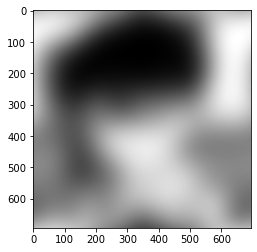

In [5]:
# calculate kx and ky of the cartoon image
kx, ky = calc_kxky(cartoon_gray)
# define our gaussian psf in fourier space
psf_fft = np.exp(-1000 * (kx**2 + ky**2))
# apply the blur function
cartoon_gray_b = blur(cartoon_gray, psf_fft)
# show the result image
plt.imshow(cartoon_gray_b, cmap='gray')

#### 1(a) Unblur the grayscale image directly

To unblur, the process is just a reverse of the blurring process: <br>
1. Fourier transform the blurred image <br>
2. Unblur the image in the fourier domain by dividing by psf_fft: <br>
<br>
$$ \text{unblurred image}_F = \frac{\text{blurred image}_F}{\text{PSF}_F + \text{adjust}} $$
<br>
where adjust is a small value to avoid dividing by zero. <br>
3. Inverse fourier transform the result back to spatial domain

When the image has three dimensions, i.e. an addtional dimension for three color channels, we need to loop through the third dimension to manipulate each of the color channel. This process is necessary for both blur and unblur.

In [6]:
# function to unblur the image
# adjust is a small value to ensure the divisor is not zero
def unblur(img_b, psf_fft, adjust):
    # fourier transform the blurred image to fourier space
    img_fft_b = fftn(img_b)
    # create a space
    img_fft = img_fft_b.copy()
    
    # when input image is grayscale, i.e. no color channel
    if len(img_b.shape) == 2:
        # divide by psf_fft to get reconstructed image in fourier space
        img_fft = img_fft_b / (psf_fft + adjust)
        
    # when input image has an additional dimension for color information
    elif len(img_b.shape) == 3:
        for i in range(3):
            # loop through color channels to unblur each channel
            img_fft[:, :, i] = img_fft_b[:, :, i] / (psf_fft + adjust)
            
    else:
        raise ValueError('Invalid image format')
        
    # convert pixel values from complex to real values      
    img = np.real(ifftn(img_fft))
    # make the pixel values stick to the range of [0.0, 1.0] for imshow()
    img -= img.min()
    img /= img.max()
    
    return img

Here we use the variable "cartoon_gray_b" directly as a comparison to later task of unblurring the loaded image.

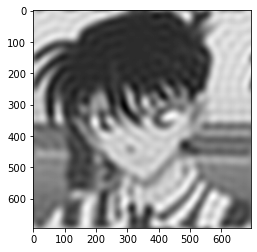

In [7]:
# small value to avoid zero divisor
adjust = 1e-13
# use unblur function to unblur the image
cartoon_gray_recon = unblur(cartoon_gray_b, psf_fft, adjust)
# show the result
plt.imshow(cartoon_gray_recon, cmap='gray')

We can see that although our method cannot reconstruct the original image perfectly, it still sharpens the blurred image to some extend.

#### 1(b) Save the grayscale image, load it and unblur

In [8]:
# Normalize the image for imwrite
cartoon_gray_b_uint8 = cv2.normalize(cartoon_gray_b, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

# Save the blurred image
cv2.imwrite('cartoon_gray_b.jpg', cartoon_gray_b_uint8)

True

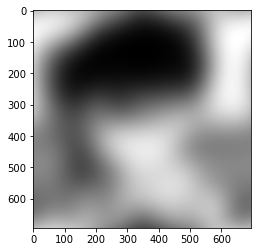

In [9]:
# load the saved image
cartoon_gray_b_loaded = cv2.imread('cartoon_gray_b.jpg', cv2.IMREAD_GRAYSCALE)
# normalize it to [0,1] for processing
cartoon_gray_b_loaded = cartoon_gray_b_loaded / 255.0
# show the loaded image
plt.imshow(cartoon_gray_b_loaded, cmap='gray')

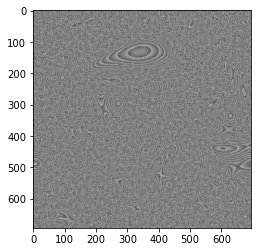

In [10]:
# small value to avoid zero divisor
adjust = 1e-13
# use unblur function to unblur the loaded image
cartoon_gray_loaded_recon = unblur(cartoon_gray_b_loaded, psf_fft, adjust)
# show the result
plt.imshow(cartoon_gray_loaded_recon, cmap='gray')

We can see that the reconstructed image looks like a salt-and-pepper noisy image when we use the loaded image as input. Comparing to 1(a), which is to use the blurred image direcly, 1(b) fails to unblur the image.

This is because when we save the blurred image to a file and then load it back before unblurring, a couple of things can happen that may affect the unblurring process: <br>
1. Information Loss: When we save and load the image, some information could be lost due to compression. <br>
2. Rounding Errors: We normalized the image multiple times during the blur and unblur process: first cast the pixel values to 8 bit [0, 255] to imwrite, and the cast the values back to [0,1] for further processing. Through these casts, some rounding errors can lead to small changes in pixel values. <br>
3. Noise: During the save and load process, some noise can be added to the image. <br>

All of the above can create noise in the image. Unfortunately, our blur and unblur methods need to map the image into fourier space (frequency space). When the image is blurred, the high-frequency components (details) of the image are reduced, since our blurring process can be considered as a low-pass filter. These reduced details can contain noise and be spread out over the blurred image. If we save and load the image, the noise can be more serious. <br>
<br>
When we try to unblur the image by dividing psf_fft in the fourier domain, we also amplifies the high-frequency noise in the image, because the divisor is small while the noise has high frequency in the fourier space. When we transform the image back to spatial domain, the noise dominates the image and that's why we eventually get a salt-and-pepper noisy image at 1(b). 

Therefore, during the unblurring process, we need to do some noise suppresion, which brings us to Wiener Deconvolution. Wiener deconvolution addresses this by dividing not by the psf_fft itself, but by the square of the magnitude of the psf_fft and modulated by a factor that depends on the power spectrum of the noise and the original image. The expression for the Wiener filter is:

$$ \text{Wiener} = \frac{1}{1 + \frac{\text{NSR}}{|\text{PSF}_F|^2}} $$

Where NSR is the noise-to-signal power ratio. Since we don't know the actual ratio in practice, we can set NSR be a constant and tune it to get the best result.

When this Wiener filter is multiplied with the fourier transformed blurred image, it suppresses the contribution of frequencies where the PSF is small (which are mostly noise) while leaving other frequencies mostly unaffected. Therefore, our unblurred image in forier space is:

$$ \text{unblurred image}_F = \frac{\text{blurred image}_F}{\text{PSF}_F + \text{adjust}} \cdot \text{Wiener} $$

#### 1(c) Use Wiener Deconvolution to unblur the loaded image

In [11]:
# function to wiener deconvolution the blurred image
def unblur_wiener(img_b, psf_fft, adjust, nsr):
    # fourier transform the blurred image to fourier space
    img_fft_b = fftn(img_b)
    # create a space
    img_fft = img_fft_b.copy()
    # define wiener filter
    wiener = 1 / (1 + (nsr / (np.abs((psf_fft + adjust)**2))))
    
    # when input image is grayscale, i.e. no color channel
    if len(img_b.shape) == 2:
        # wiener deconvolution
        img_fft = img_fft_b / (psf_fft + adjust) * wiener
        
    # when input image has an additional dimension for color information
    elif len(img_b.shape) == 3:
        for i in range(3):
            # loop through color channels to unblur each channel
            img_fft[:, :, i] = img_fft_b[:, :, i] / (psf_fft + adjust) * wiener
    else:
        raise ValueError('Invalid image format')
        
    # convert pixel values from complex to real values
    img = np.real(ifftn(img_fft))
    # make the pixel values stick to the range of [0.0, 1.0] for imshow()
    img -= img.min()
    img /= img.max()
    
    return img

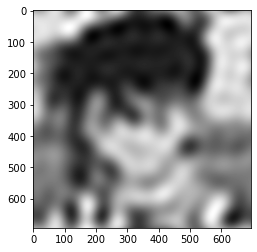

In [12]:
adjust = 1e-8
nsr = 0.000001
cartoon_gray_loaded_wiener = unblur_wiener(cartoon_gray_b_loaded, psf_fft, adjust, nsr)
# show the result
plt.imshow(cartoon_gray_loaded_wiener, cmap='gray')

We can see that the result looks better than the salt-and-pepper noisy image we got in 1(b).

#### 2. Blur and unblur the RGB real image

In this section, we will explore the real image taken by my phone, which has higher resolution and has an additional dimension for color information. Here I would use a picture of my hamster as a sample.

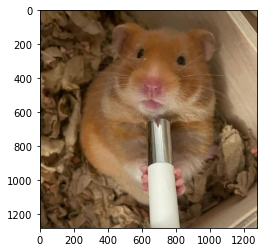

In [13]:
# read the image from local
hamster = cv2.imread('pixar.jpg')
# use cv2 to convert it to RGB
hamster = cv2.cvtColor(hamster, cv2.COLOR_BGR2RGB)
plt.imshow(hamster)

The blur and unblur processes are similar to section 1. Since I've written rgb conditions in my previous function, we can directly use them in this section.

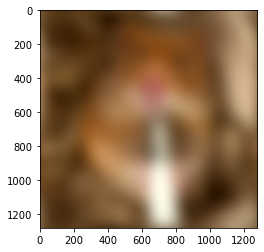

In [14]:
# calculate kx and ky of the image
kx, ky = calc_kxky(hamster)
# define our gaussian psf in fourier space
psf_fft = np.exp(-1000 * (kx**2 + ky**2))
# apply the blur function
hamster_b = blur(hamster, psf_fft)
# show the result image
plt.imshow(hamster_b)

#### 2(a) Unblur the real image directly

Here we use the variable "hamster_b" directly as a comparison to later task of unblurring the loaded image.

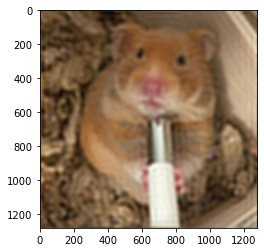

In [15]:
# small value to avoid zero divisor
adjust = 1e-13
# use unblur function to unblur the image
hamster_recon = unblur(hamster_b, psf_fft, adjust)
# show the result
plt.imshow(hamster_recon)

We can see that the result is pretty good.

#### 2(b) Save the blurred image, load it and unblur

In [16]:
# Normalize the image for imwrite
hamster_b_uint8 = cv2.normalize(hamster_b, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
# Convert to BGR before saving
hamster_b_bgr = cv2.cvtColor(hamster_b_uint8, cv2.COLOR_RGB2BGR)

# Save the blurred image
cv2.imwrite('hamster_b.jpg', hamster_b_bgr)

True

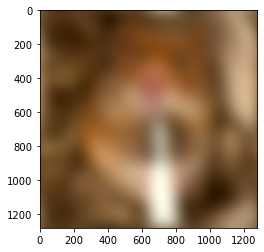

In [17]:
# load the saved image
hamster_b_loaded = cv2.imread('hamster_b.jpg')
hamster_b_loaded = cv2.cvtColor(hamster_b_loaded, cv2.COLOR_BGR2RGB)
# normalize it to [0,1] for processing
hamster_b_loaded = hamster_b_loaded / 255.0
# show the loaded image
plt.imshow(hamster_b_loaded)

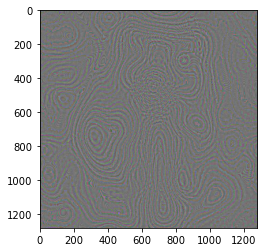

In [18]:
# small value to avoid zero divisor
adjust = 1e-13
# use unblur function to unblur the loaded image
hamster_loaded_recon = unblur(hamster_b_loaded, psf_fft, adjust)
# show the result
plt.imshow(hamster_loaded_recon)

Once again, the result is noisy. We need to do wiener deconvolution to see if it can be improved.

#### 2(c) Use Wiener Deconvolution to unblur the loaded image

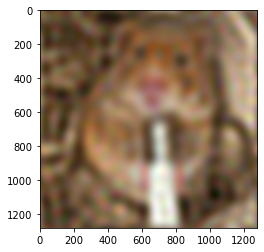

In [19]:
adjust = 1e-8
nsr = 0.0001
hamster_loaded_wiener = unblur_wiener(hamster_b_loaded, psf_fft, adjust, nsr)
# show the result
plt.imshow(hamster_loaded_wiener)

We can see that the result looks much better.

#### 3. When PSF is not an analytic function

In practice, it is common that we cannot get the psf expression. For example, if we take a picture of a galaxy, the result could be blurred, and we do not know the psf of it. To solve this problem, we can use the same camera to take a picture of a single light point, analyzing the blurred light point image with the clear light point image to get the psf. Then we can use this psf to unblur the picture of galaxy. In this section, we will explore how to get the psf from the light point picture and how to use it to unblur the image that is blurred under same condition:

(a) Get PSF from two pictures: an online picture that shows a spread, and a filtered picture that mimics the original light point <br>
(b) Use this PSF to blur my hamster's picture, and unblur it directly <br>
(c) Use this PSF to unblur the loaded blurred image <br>
(d) Use Wiener Deconvolution to unblur the loaded blurred image

#### 3(a) Get the PSF from image of a light point

Due to some limitations, I failed to take perfect pictures of a point light in dark background. Therefore, here I will use an online picture to get a psf: https://irsa.ipac.caltech.edu/data/SPITZER/docs/irac/calibrationfiles/psfprf/

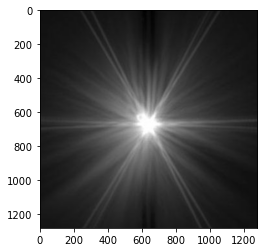

In [20]:
# read the spread picture
spread = cv2.imread('spread.png')
# convert to rgb
spread = cv2.cvtColor(spread, cv2.COLOR_BGR2RGB)
# since I will use my hamster's picture, the image of spread should be resized
spread = cv2.resize(spread, (hamster.shape[1], hamster.shape[0]))

plt.imshow(spread)

To get the PSF from this picture, we need to have a point image:

$$
\text{PSF}(x, y) = \int dx' \, dy' \, \text{PSF}(x - x', y - y') \, \delta(x') \, \delta(y')
$$


Where the deltas in this formula is the point image we are looking for. To get this, we can set a threshold and filt the spread image so that only the point in the center is preserved.

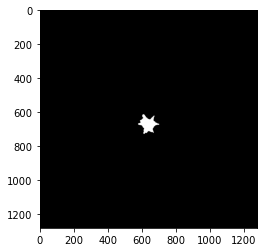

In [21]:
# Start with a copy of the original image
point = spread.copy()
threshold = 250
# Create a mask to select all pixels that are not completely white
mask = (point[:,:,0] < threshold) | (point[:,:,1] < threshold) | (point[:,:,2] < threshold)
# Set these pixels to black
point[mask] = [0, 0, 0]

plt.imshow(point)

Now we need to get PSF from these two images. Consider "point" is the original image and "spread" is the blurred image, we know that in fourier space,

$$
\text{PSF}_F = \frac{\text{blurred image}_F}{\text{original image}_F}
$$

In [22]:
# function to get psf_fft from two images
def get_psf(img, img_b, adjust):
    # fourier transform the two images
    img_fft = fftn(img)
    img_b_fft = fftn(img_b)
    # create a space
    psf_fft = img_fft.copy()
    # loop through channels
    for i in range(3):
        psf_fft[:,:,i] = img_b_fft[:,:,i] / (img_fft[:,:,i] + adjust)
    
    # cast and normalize the psf so that sum of it is 1
    psf = np.real(ifftn(psf_fft))
    psf /= np.sum(psf)
    
    # return the psf in fourier space    
    return fftn(psf)

In [23]:
# get our psf_fft from images
psf_fft_data = get_psf(point, spread, adjust)

In [24]:
psf_fft_data.shape

(1280, 1280, 3)

Notice that since we are subtracting psf from an rgb image, the psf here also has a color channel dimesion. This is different from the analytical psf we dealt before, which only has two dimensions. Therefore, we want to discard the third dimension entirely so that it will not affect the color of the image.

In [25]:
psf_fft_data = psf_fft_data[:,:,0]

First we can test if we subtracted the psf correctly by using this psf to blur our point image:

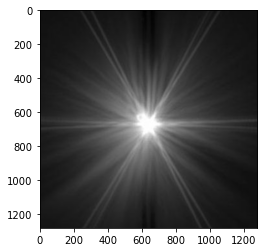

In [26]:
point_b = blur(point, psf_fft_data)
plt.imshow(point_b)

We can see that the blurred image looks similar to our spread image. This indicates that our psf is correct.

#### 3(b) Use this PSF to blur real image, and unblur it directly

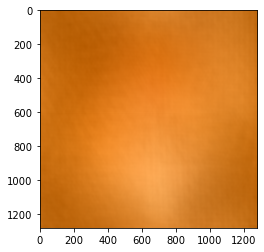

In [27]:
# blur the hamster image using the psf data
hamster_data_b = blur(hamster, psf_fft_data)
plt.imshow(hamster_data_b)

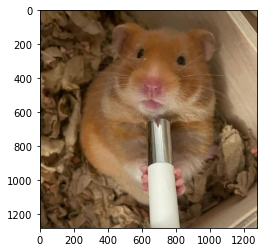

In [28]:
# unblur it directly using our previous function
adjust = 1e-13
hamster_data_recon = unblur(hamster_data_b, psf_fft_data, adjust)
plt.imshow(hamster_data_recon)

We can see that it looks even better than using the analytical psf. I am confused here.

#### 3(c) Use this PSF to unblur the loaded blurred image

In [29]:
# Normalize the image for imwrite
hamster_data_b_uint8 = cv2.normalize(hamster_data_b, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
# Convert to BGR before saving
hamster_data_b_bgr = cv2.cvtColor(hamster_data_b_uint8, cv2.COLOR_RGB2BGR)

# Save the blurred image
cv2.imwrite('hamster_data_b.jpg', hamster_data_b_bgr)

True

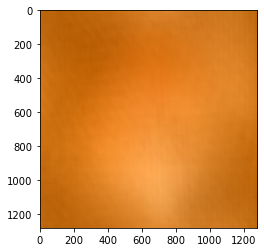

In [30]:
# load the saved image
hamster_data_b_loaded = cv2.imread('hamster_data_b.jpg')
hamster_data_b_loaded = cv2.cvtColor(hamster_data_b_loaded, cv2.COLOR_BGR2RGB)
# normalize it to [0,1] for processing
hamster_data_b_loaded = hamster_data_b_loaded / 255.0
# show the loaded image
plt.imshow(hamster_data_b_loaded)

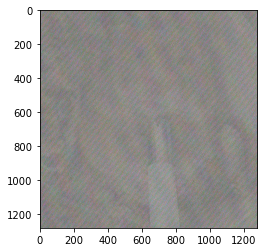

In [31]:
# small value to avoid zero divisor
adjust = 1e-13
# use unblur function to unblur the loaded image
hamster_data_loaded_recon = unblur(hamster_data_b_loaded, psf_fft_data, adjust)
# show the result
plt.imshow(hamster_data_loaded_recon)

We can see that there are noise through the image. Use Wiener to see if it can be improved.

#### 3(d) Use Wiener Deconvolution to unblur the loaded blurred image

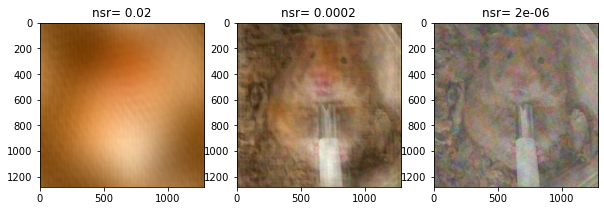

In [32]:
adjust = 1e-8
nsrs = [0.02, 0.0002, 0.000002]
fig, axs = plt.subplots(1, 3, figsize=(10, 15))
for i in range(len(nsrs)):
    hamster_data_loaded_wiener = unblur_wiener(hamster_data_b_loaded, 
                                               psf_fft_data, adjust, nsrs[i])
    
    axs[i].imshow(hamster_data_loaded_wiener)
    axs[i].set_title(f'nsr= {nsrs[i]}')

We can see that Wiener Deconvolution and unblur the loaded image better than normal method. We can also notice that there is a trade-off between color and sharpness: when NSR is smaller, the color is more saturated but the image is more blurred; when NSR is large, the image is sharper but the color is less saturated, which is actually the gray caused by noise.

### Conclusion

In this project, we applied Fast Fourier Transforms (FFT) for image processing, particularly in image blurring and unblurring. Through manipulating an image in the frequency domain using FFT, we can blur the image and unblur it to a certain extent.

First, we explored the process of blurring and unblurring grayscale and RGB images. While we were able to unblur the blurred image directly, the restoration was less effective when working with loaded blurred images. This was due to information loss and noise introduced during the save and load process, as well as during normalization of the pixel values.

To overcome these limitations, we have utilized Wiener Deconvolution, a more advanced technique for image restoration. It reduces the noise amplification during fourier transforms, resulting in a more effective restoration of the loaded blurred images.

Finally, we explored the condition where the Point Spread Function is not analytic but instead has to be derived from blurred and filtered images. Using this non-analytic PSF, we could blur and unblur our target images even better. In this case, the Wiener Deconvolution still outperfoms the standard method.